<a href="https://colab.research.google.com/github/w-olszewski/Brain_MRI_segmentation/blob/main/U_NET_test_IBSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install torchio
!pip install torchmetrics
from torchmetrics.functional import dice
import xml.etree.ElementTree as ET
import pandas as pd
import multiprocessing
import torch
import torchio as tio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import glob
from pathlib import Path
import nibabel as nib
import enum
import torchvision
from tqdm import tqdm
from IPython import display
from scipy import stats
import tarfile

In [ ]:
# Accessing dataset

from google.colab import drive
drive.mount('/content/MyDrive')

datafiles = os.path.abspath('/content/MyDrive/MyDrive/Colab_Notebooks/UNET/MICCAI_MultiAtlasChallenge2012_corrected/Testing/IBSR')

datafiles_dir = Path(datafiles)

%cd /content/MyDrive/MyDrive/Colab_Notebooks/UNET/MICCAI_MultiAtlasChallenge2012_corrected/Testing/IBSR


In [ ]:
images_dir = os.path.abspath('Images')
masks_dir = os.path.abspath('LabelMap')

images = []

image_names = sorted(os.listdir(images_dir))
for image_name in image_names:
    image = tio.ScalarImage(os.path.join(images_dir, image_name))
    images.append(image)

labels = []

label_names = sorted(os.listdir(masks_dir))
for label_name in label_names:
    label = tio.LabelMap(os.path.join(masks_dir, label_name))
    labels.append(label)

x = 0

subjects = []
for (image, label) in zip(images, labels):
    subject = tio.Subject(
        mri= image,
        brain= label,
        name = (image_names[x])
    )
    x += 1

    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

In [ ]:
names = [subject.name for subject in dataset.dry_iter()]
print(names)

In [ ]:
img_dir = datafiles_dir / '../Images'

img_paths = sorted(img_dir.glob('*.nii'))

num_workers = multiprocessing.cpu_count()
histogram_landmarks_path = 'landmarks.npy'
landmarks = tio.HistogramStandardization.train(
    img_paths,
    output_path=histogram_landmarks_path,
)

np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

In [ ]:
landmarks_dict = {'mri': landmarks}

testing_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.HistogramStandardization(landmarks_dict),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

testing_set = tio.SubjectsDataset(
    dataset, transform=testing_transform)

In [ ]:
#@title
# U-NET model
# 4 convolution layers

class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=208, num_filter=32):
        super(UNet, self).__init__()

        # Encoder path

        n = num_filter  # 32
        self.conv1 = nn.Sequential(
            nn.Conv3d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        n = n * 2  # 64
        self.conv2 = nn.Sequential(
            nn.Conv3d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        n = n * 2  # 128
        self.conv3 = nn.Sequential(
            nn.Conv3d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        n = n * 2  # 256
        self.conv4 = nn.Sequential(
            nn.Conv3d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.drop = nn.Dropout(p=0.5)

       # Decoder path

        n = int(n / 2)  # 128
        self.up3 = nn.ConvTranspose3d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv_up3 = nn.Sequential(
            nn.Conv3d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 64
        self.up2 = nn.ConvTranspose3d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv_up2 = nn.Sequential(
            nn.Conv3d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        self.up1 = nn.ConvTranspose3d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv_up1 = nn.Sequential(
            nn.Conv3d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.out = nn.Conv3d(n, output_channel, kernel_size=1, padding=0)

    def forward(self, x):

        x = self.conv1(x)
        conv1_skip = x

        x = self.pool1(x)

        x = self.conv2(x)
        conv2_skip = x

        x = self.pool2(x)

        x = self.conv3(x)
        conv3_skip = x

        x = self.pool3(x)

        x = self.conv4(x)

        x = self.drop(x)

        x = self.up3(x)
        x = self.conv_up3(torch.cat([conv3_skip, x], dim=1))

        x = self.up2(x)
        x = self.conv_up2(torch.cat([conv2_skip, x], dim=1))

        x = self.up1(x)
        x = self.conv_up1(torch.cat([conv1_skip, x], dim=1))

        x = self.out(x)

        return x


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

def prepare_batch(batch, device):
    inputs = batch['mri'][tio.DATA].to(device)
    return inputs


In [ ]:
model_dir = '../../Training/saved_models'

model = UNet().to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'), map_location=device))

subject = random.choice(testing_set)

patch_size = 48, 48, 48
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=16)
aggregator = tio.inference.GridAggregator(
    grid_sampler, 'average')


for batch_idx, batch in enumerate(tqdm(patch_loader)):
    images = prepare_batch(batch, device)
images = images.clone().detach()
images = images.to(device, dtype=torch.float32)


model.eval()
with torch.no_grad():
    for batch in patch_loader:
        locations = batch[tio.LOCATION]
        logits = model(images)
        seg_patch = logits.argmax(dim=1, keepdim=True)
        outputs = seg_patch
        aggregator.add_batch(outputs, locations)

predicted = aggregator.get_output_tensor().to(device)


In [ ]:
print(subject.name)

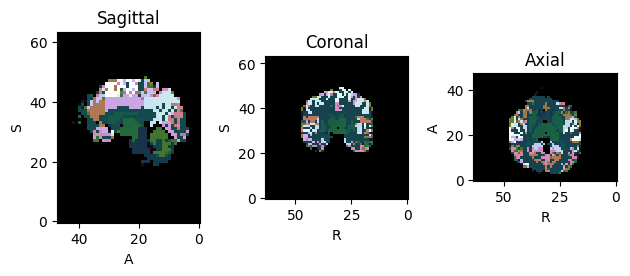

LabelMap(shape: (1, 64, 48, 64); spacing: (4.00, 4.00, 4.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 768.0 KiB)


In [ ]:
predicted = predicted.cpu().numpy()
affine = subject.mri.affine
segmentation = tio.LabelMap(tensor=predicted, affine=affine)

segmentation.plot()
print(segmentation)

In [ ]:
img_dir = datafiles_dir / 'Images'
raw_image = img_dir / str(subject.name)
print(str(raw_image))

In [ ]:
segmentation = tio.Resample(raw_image)(segmentation)

In [ ]:
segmentation = np.squeeze(segmentation, axis=0)
print(segmentation.shape)

In [ ]:
nib.Nifti1Header.quaternion_threshold = -1e-06
nim = nib.load(raw_image)

Nifty = nib.Nifti1Image(segmentation, nim.affine)
Nifty.header['pixdim'] = nim.header['pixdim']
nib.save(Nifty, filename='segmentation_' + str(subject.name))

In [ ]:
target_dir = datafiles_dir / 'LabelMap'

target_name = target_dir / str(subject.name)

target = nib.load(target_name)

target = nib.squeeze_image(target)

def np_categorical_dice(pred, truth, k, k1):
    """ Dice overlap metric for label k """
    A = (pred == k).astype(np.float32)
    B = (truth == k1).astype(np.float32)
    return 2 * np.sum(A * B) / (np.sum(A) + np.sum(B))

In [ ]:
for k in range(85):
    dice = np_categorical_dice(Nifty.get_fdata(), target.get_fdata(), k)
    print('Label '+str(k)+' has dice score '+str(dice))

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

label_list = datafiles_dir / '''''''''''''insert .xml dir'''''''''''''

xml_data = open(label_list, 'r').read()
root = ET.XML(xml_data)

data = []
cols = []
for i, child in enumerate(root):
    data.append([subchild.text for subchild in child])
    cols.append(child.tag)

df = pd.DataFrame(data, dtype=str)
df.columns = ['Name', 'Index', 'RGBColor']
df.columns = df.columns.astype(str)
print(df)

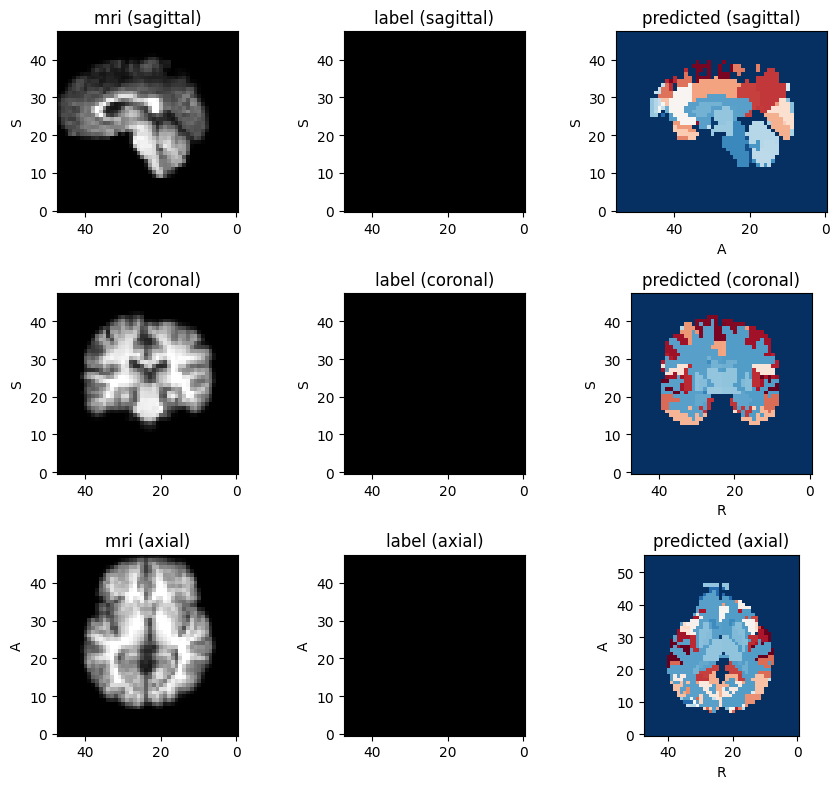

In [ ]:
FIRST = 0

subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST]),
    label=tio.LabelMap(tensor=batch['brain'][tio.DATA][FIRST]),
    predicted=tio.ScalarImage(tensor=predicted),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})